In [4]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 200)
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'monospace'
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, log_loss

import os, eli5, shap
from eli5.sklearn import PermutationImportance
from pdpbox import pdp


In [7]:
df_NCAA_all = pd.read_csv('H:/NCAA/NCAA2019/data/stage2datafiles/NCAATourneyCompactResults.csv')

In [8]:
df = pd.read_csv('H:/NCAA/NCAA2019/data/stage2datafiles/RegularSeasonDetailedResults.csv')

In [9]:
df = df[df.Season > 2008]

In [10]:
past_teams = list(set(list(df_NCAA_all.WTeamID.unique()) + list(df_NCAA_all.LTeamID.unique()))) 
len(past_teams)

298

In [12]:
df_predict = pd.read_csv('H:/NCAA/NCAA2019/data/SampleSubmissionStage2.csv')
grp1 = list(set(df_predict.apply(lambda row: row.ID.split('_')[1], axis=1)))
grp2 = list(set(df_predict.apply(lambda row: row.ID.split('_')[2], axis=1)))
crnt_trny_teams = list(set(grp1 + grp2))
len(crnt_trny_teams)

68

In [15]:
# Save dataframes with Team and Conference names:
df_teams = pd.read_csv('H:/NCAA/NCAA2019/data/stage2datafiles/Teams.csv')
df_team_conferences = pd.read_csv('H:/NCAA/NCAA2019/data/stage2datafiles/TeamConferences.csv')
df_conferences = pd.read_csv('H:/NCAA/NCAA2019/data/stage2datafiles/Conferences.csv')

# Merge the conference dataframes to eventually use the full conference name:
df_conference_names = df_team_conferences.merge(df_conferences, on=['ConfAbbrev'])

# Pre-merge tidying to match with winner and loser IDs:
win_teams = df_teams.rename(columns={'TeamID':'WTeamID'})[['WTeamID', 'TeamName']]
win_confs = df_conference_names.rename(columns={'TeamID':'WTeamID'})[['Season', 'WTeamID', 'Description']]
lose_teams = df_teams.rename(columns={'TeamID':'LTeamID'})[['LTeamID', 'TeamName']]
lose_confs = df_conference_names.rename(columns={'TeamID':'LTeamID'})[['Season', 'LTeamID', 'Description']]

# Merge winning team name and conference, losing team name and conference with season results:
df = df.merge(win_teams, on='WTeamID').rename(columns={'TeamName': 'WTeamName'}) \
.merge(win_confs, on=['Season', 'WTeamID']).rename(columns={'Description': 'WConfName'}) \
.merge(lose_teams, on='LTeamID').rename(columns={'TeamName': 'LTeamName'}) \
.merge(lose_confs, on=['Season', 'LTeamID']).rename(columns={'Description': 'LConfName'})
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,WTeamName,WConfName,LTeamName,LConfName
0,2009,7,1181,80,1342,49,30,63,3,11,17,21,14,30,13,21,17,4,21,16,53,3,17,14,19,10,19,4,28,5,5,25,Duke,Atlantic Coast Conference,Presbyterian,Big South Conference
1,2009,8,1222,76,1342,57,30,56,6,15,10,15,8,18,12,9,11,1,23,16,40,6,21,19,24,8,20,8,19,5,3,18,Houston,Conference USA,Presbyterian,Big South Conference
2,2009,25,1155,79,1342,58,31,58,5,14,12,17,9,29,19,8,10,6,14,23,49,7,20,5,13,5,20,12,15,4,0,17,Clemson,Atlantic Coast Conference,Presbyterian,Big South Conference
3,2009,18,1208,55,1342,47,25,52,3,7,2,11,11,20,10,13,7,4,16,17,45,6,17,7,10,10,21,10,21,6,4,14,Georgia,Southeastern Conference,Presbyterian,Big South Conference
4,2009,55,1266,84,1342,45,31,63,9,22,13,16,16,28,23,8,7,3,10,17,47,5,20,6,7,2,18,8,13,5,7,16,Marquette,Big East Conference,Presbyterian,Big South Conference


In [16]:
df['WFGM2'] = df.WFGM - df.WFGM3
df['WFGA2'] = df.WFGA - df.WFGA3
df['LFGM2'] = df.LFGM - df.LFGM3
df['LFGA2'] = df.LFGA - df.LFGA3

In [17]:
df[['WFGA', 'WFTA', 'WTO', 'WOR', 'WScore', 'WFGM2', 'WFGM3', 'WFGM', 'WFTM', 'WDR', 'WAst', 'WStl', 'WBlk', 'WPF']].describe()

,WFGA,WFTA,WTO,WOR,WScore,WFGM2,WFGM3,WFGM,WFTM,WDR,WAst,WStl,WBlk,WPF
count,58679.000000,58679.000000,58679.000000,58679.000000,58679.000000,58679.000000,58679.000000,58679.000000,58679.000000,58679.000000,58679.000000,58679.000000,58679.000000,58679.000000
mean,55.348404,22.573698,12.499991,10.634367,75.656112,18.940950,7.230525,26.171475,16.082636,26.038344,14.554355,6.758738,3.882599,17.411323
std,7.449894,8.100521,3.874835,4.076768,11.097986,4.633628,3.120747,4.679329,6.242820,4.880821,4.385980,3.002264,2.439898,4.147068
min,27.000000,0.000000,1.000000,0.000000,34.000000,2.000000,0.000000,10.000000,0.000000,8.000000,1.000000,0.000000,0.000000,3.000000
25%,50.000000,17.000000,10.000000,8.000000,68.000000,16.000000,5.000000,23.000000,12.000000,23.000000,11.000000,5.000000,2.000000,15.000000
50%,55.000000,22.000000,12.000000,10.000000,75.000000,19.000000,7.000000,26.000000,16.000000,26.000000,14.000000,6.000000,4.000000,17.000000
75%,60.000000,28.000000,15.000000,13.000000,83.000000,22.000000,9.000000,29.000000,20.000000,29.000000,17.000000,9.000000,5.000000,20.000000
max,103.000000,67.000000,33.000000,38.000000,144.000000,48.000000,26.000000,56.000000,47.000000,53.000000,40.000000,26.000000,18.000000,40.000000


In [18]:
df[['LFGA', 'LFTA', 'LTO', 'LOR', 'LScore', 'LFGM2', 'LFGM3', 'LFGM', 'LFTM', 'LDR', 'LAst', 'LStl', 'LBlk', 'LPF']].describe()

,LFGA,LFTA,LTO,LOR,LScore,LFGM2,LFGM3,LFGM,LFTM,LDR,LAst,LStl,LBlk,LPF
count,58679.000000,58679.000000,58679.000000,58679.000000,58679.000000,58679.000000,58679.000000,58679.000000,58679.000000,58679.000000,58679.000000,58679.000000,58679.000000,58679.000000
mean,56.543124,18.170112,13.762931,10.838562,63.692275,16.528503,6.106341,22.634844,12.316246,21.948210,11.281532,5.829240,2.909252,19.648426
std,7.594306,7.134292,4.205335,4.164426,10.988041,4.294848,2.803123,4.384975,5.381401,4.521298,3.687185,2.688216,2.032809,4.525234
min,29.000000,0.000000,0.000000,0.000000,22.000000,2.000000,0.000000,6.000000,0.000000,4.000000,0.000000,0.000000,0.000000,4.000000
25%,51.000000,13.000000,11.000000,8.000000,56.000000,14.000000,4.000000,20.000000,8.000000,19.000000,9.000000,4.000000,1.000000,17.000000
50%,56.000000,18.000000,13.000000,10.000000,63.000000,16.000000,6.000000,23.000000,12.000000,22.000000,11.000000,6.000000,3.000000,19.000000
75%,61.000000,23.000000,16.000000,13.000000,71.000000,19.000000,8.000000,25.000000,16.000000,25.000000,14.000000,7.000000,4.000000,23.000000
max,106.000000,61.000000,40.000000,36.000000,127.000000,39.000000,22.000000,45.000000,42.000000,49.000000,30.000000,19.000000,17.000000,45.000000


In [19]:
# Winner stats related to offensive efficiency:
df['Wposs'] = df.apply(lambda row: row.WFGA + 0.475 * row.WFTA + row.WTO - row.WOR, axis=1)
df['Wshoot_eff'] = df.apply(lambda row: row.WScore / (row.WFGA + 0.475 * row.WFTA), axis=1)
df['Wscore_op'] = df.apply(lambda row: (row.WFGA + 0.475 * row.WFTA) / row.Wposs, axis=1)
df['Woff_rtg'] = df.apply(lambda row: row.WScore/row.Wposs*100, axis=1)

# Loser stats related to offensive efficiency:
df['Lposs'] = df.apply(lambda row: row.LFGA + 0.475 * row.LFTA + row.LTO - row.LOR, axis=1)
df['Lshoot_eff'] = df.apply(lambda row: row.LScore / (row.LFGA + 0.475 * row.LFTA), axis=1)
df['Lscore_op'] = df.apply(lambda row: (row.LFGA + 0.475 * row.LFTA) / row.Lposs, axis=1)
df['Loff_rtg'] = df.apply(lambda row: row.LScore/row.Lposs*100, axis=1)

# Defensive and net efficiency:
df['Wdef_rtg'] = df.apply(lambda row: row.Loff_rtg, axis=1)
df['Wsos'] = df.apply(lambda row: row.Woff_rtg - row.Loff_rtg, axis=1)
df['Ldef_rtg'] = df.apply(lambda row: row.Woff_rtg, axis=1)
df['Lsos'] = df.apply(lambda row: row.Loff_rtg - row.Woff_rtg, axis=1)

# Impact Estimate - 
# First calculate the teams' overall statistical contribution (the numerator):
Wie = df.apply(lambda row: row.WScore + row.WFGM + row.WFTM - row.WFGA - row.WFTA + row.WDR + (0.5 * row.WOR) + row.WAst + row.WStl + (0.5 * row.WBlk) - row.WPF - row.WTO, axis=1)
Lie = df.apply(lambda row: row.LScore + row.LFGM + row.LFTM - row.LFGA - row.LFTA + row.LDR + (0.5 * row.LOR) + row.LAst + row.LStl + (0.5 * row.LBlk) - row.LPF - row.LTO, axis=1)

# Then divide by the total game statistics (the denominator):
df['Wie'] = Wie / (Wie + Lie) * 100
df['Lie'] = Lie / (Lie + Wie) * 100

# Other winner stats:
df['Wts_pct'] = df.apply(lambda row: row.WScore / (2 * (row.WFGA + 0.475 * row.WFTA)) * 100, axis=1)
df['Wefg_pct'] = df.apply(lambda row: (row.WFGM2 + 1.5 * row.WFGM3) / row.WFGA, axis=1)
df['Worb_pct'] = df.apply(lambda row: row.WOR / (row.WOR + row.LDR), axis=1)
df['Wdrb_pct'] = df.apply(lambda row: row.WDR / (row.WDR + row.LOR), axis=1)
df['Wreb_pct'] = df.apply(lambda row: (row.Worb_pct + row.Wdrb_pct) / 2, axis=1)
df['Wto_poss'] = df.apply(lambda row: row.WTO / row.Wposs, axis=1)
df['Wft_rate'] = df.apply(lambda row: row.WFTM / row.WFGA, axis=1)
df['Wast_rtio'] = df.apply(lambda row: row.WAst / (row.WFGA + 0.475*row.WFTA + row.WTO + row.WAst) * 100, axis=1)
df['Wblk_pct'] = df.apply(lambda row: row.WBlk / row.LFGA2 * 100, axis=1)
df['Wstl_pct'] = df.apply(lambda row: row.WStl / row.Lposs * 100, axis=1)
df['W3pta_pct'] = df.apply(lambda row: row.WFGA3 / row.WFGA * 100, axis=1)

# Other loser stats:
df['Lts_pct'] = df.apply(lambda row: row.LScore / (2 * (row.LFGA + 0.475 * row.LFTA)) * 100, axis=1)
df['Lefg_pct'] = df.apply(lambda row: (row.LFGM2 + 1.5 * row.LFGM3) / row.LFGA, axis=1)
df['Lorb_pct'] = df.apply(lambda row: row.LOR / (row.LOR + row.WDR), axis=1)
df['Ldrb_pct'] = df.apply(lambda row: row.LDR / (row.LDR + row.WOR), axis=1)
df['Lreb_pct'] = df.apply(lambda row: (row.Lorb_pct + row.Ldrb_pct) / 2, axis=1)
df['Lto_poss'] = df.apply(lambda row: row.LTO / row.Lposs, axis=1)
df['Lft_rate'] = df.apply(lambda row: row.LFTM / row.LFGA, axis=1)
df['Last_rtio'] = df.apply(lambda row: row.LAst / (row.LFGA + 0.475*row.LFTA + row.LTO + row.LAst) * 100, axis=1)
df['Lblk_pct'] = df.apply(lambda row: row.LBlk / row.WFGA2 * 100, axis=1)
df['Lstl_pct'] = df.apply(lambda row: row.LStl / row.Wposs * 100, axis=1)
df['L3pta_pct'] = df.apply(lambda row: row.LFGA3 / row.LFGA * 100, axis=1)

# Calculate weighted factors for winners and losers:
df['Wfour'] = df.apply(lambda row: 0.4*row.Wefg_pct + 0.25*row.Wto_poss + 0.2*row.Worb_pct + 0.15*row.Wft_rate, axis=1)
df['Lfour'] = df.apply(lambda row: 0.4*row.Lefg_pct + 0.25*row.Lto_poss + 0.2*row.Lorb_pct + 0.15*row.Lft_rate, axis=1)

In [20]:
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,WTeamName,WConfName,LTeamName,LConfName,WFGM2,WFGA2,LFGM2,LFGA2,Wposs,Wshoot_eff,Wscore_op,Woff_rtg,Lposs,Lshoot_eff,Lscore_op,Loff_rtg,Wdef_rtg,Wsos,Ldef_rtg,Lsos,Wie,Lie,Wts_pct,Wefg_pct,Worb_pct,Wdrb_pct,Wreb_pct,Wto_poss,Wft_rate,Wast_rtio,Wblk_pct,Wstl_pct,W3pta_pct,Lts_pct,Lefg_pct,Lorb_pct,Ldrb_pct,Lreb_pct,Lto_poss,Lft_rate,Last_rtio,Lblk_pct,Lstl_pct,L3pta_pct,Wfour,Lfour
0,2009,7,1181,80,1342,49,30,63,3,11,17,21,14,30,13,21,17,4,21,16,53,3,17,14,19,10,19,4,28,5,5,25,Duke,Atlantic Coast Conference,Presbyterian,Big South Conference,27,52,13,36,79.975,1.096266,0.912473,100.031260,80.025,0.790004,0.775070,61.230865,61.230865,38.800394,100.031260,-38.800394,117.647059,-17.647059,54.813292,0.500000,0.424242,0.750000,0.587121,0.262582,0.269841,12.152372,11.111111,21.243361,17.460317,39.500202,0.330189,0.250000,0.575758,0.412879,0.349891,0.264151,4.254188,9.615385,6.251954,32.075472,0.390970,0.309171
1,2009,8,1222,76,1342,57,30,56,6,15,10,15,8,18,12,9,11,1,23,16,40,6,21,19,24,8,20,8,19,5,3,18,Houston,Conference USA,Presbyterian,Big South Conference,24,41,10,19,64.125,1.203960,0.984405,118.518519,62.400,1.108949,0.823718,91.346154,91.346154,27.172365,118.518519,-27.172365,66.477273,33.522727,60.198020,0.589286,0.285714,0.692308,0.489011,0.140351,0.178571,14.264487,5.263158,17.628205,26.785714,55.447471,0.475000,0.307692,0.714286,0.510989,0.304487,0.475000,10.204082,7.317073,7.797271,52.500000,0.354731,0.398910
2,2009,25,1155,79,1342,58,31,58,5,14,12,17,9,29,19,8,10,6,14,23,49,7,20,5,13,5,20,12,15,4,0,17,Clemson,Atlantic Coast Conference,Presbyterian,Big South Conference,26,44,16,29,65.075,1.195611,1.015367,121.398386,65.175,1.051201,0.846567,88.991178,88.991178,32.407209,121.398386,-32.407209,74.793388,25.206612,59.780552,0.577586,0.310345,0.852941,0.581643,0.122935,0.206897,20.413645,20.689655,15.343306,24.137931,52.560036,0.540816,0.147059,0.689655,0.418357,0.230150,0.102041,14.602981,0.000000,6.146754,40.816327,0.354872,0.318582
3,2009,18,1208,55,1342,47,25,52,3,7,2,11,11,20,10,13,7,4,16,17,45,6,17,7,10,10,21,10,21,6,4,14,Georgia,Southeastern Conference,Presbyterian,Big South Conference,22,45,11,28,59.225,0.961118,0.966230,92.866188,60.750,0.944724,0.818930,77.366255,77.366255,15.499933,92.866188,-15.499933,57.983193,42.016807,48.055920,0.509615,0.343750,0.666667,0.505208,0.219502,0.038462,12.464942,14.285714,11.522634,13.461538,47.236181,0.444444,0.333333,0.656250,0.494792,0.345679,0.155556,12.383901,8.888889,10.130857,37.777778,0.333241,0.354198
4,2009,55,1266,84,1342,45,31,63,9,22,13,16,16,28,23,8,7,3,10,17,47,5,20,6,7,2,18,8,13,5,7,16,Marquette,Big East Conference,Presbyterian,Big South Conference,22,41,12,27,62.600,1.189802,1.127796,134.185304,61.325,0.894188,0.820628,73.379535,73.379535,60.805768,134.185304,-60.805768,82.773109,17.226891,59.490085,0.563492,0.470588,0.933333,0.701961,0.127796,0.206349,22.637795,11.111111,11.414594,34.920635,44.709389,0.414894,0.066667,0.529412,0.298039,0.211985,0.127660,11.216264,17.073171,7.987220,42.553191,0.382416,0.251436


In [22]:
df_avgs = pd.DataFrame()

# Get and save number of wins and losses:
df_avgs['n_wins'] = df['WTeamID'].groupby([df.Season, df.WTeamID, df.WTeamName, df.WConfName]).count()
df_avgs['n_loss'] = df['LTeamID'].groupby([df.Season, df.LTeamID, df.LTeamName, df.LConfName]).count()

df_avgs['n_loss'].fillna(0, inplace=True)

# Calculate win percentages:
df_avgs['win_pct'] = df_avgs['n_wins'] / (df_avgs['n_wins'] + df_avgs['n_loss'])

In [23]:
# Calculate averages for games won:
df_avgs['Wshoot_eff'] = df['Wshoot_eff'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Wscore_op'] = df['Wscore_op'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Woff_rtg'] = df['Woff_rtg'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Wdef_rtg'] = df['Wdef_rtg'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Wsos'] = df['Wsos'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Wts_pct'] = df['Wts_pct'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Wefg_pct'] = df['Wefg_pct'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Worb_pct'] = df['Worb_pct'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Wdrb_pct'] = df['Wdrb_pct'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Wreb_pct'] = df['Wreb_pct'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Wto_poss'] = df['Wto_poss'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Wft_rate'] = df['Wft_rate'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Wie'] = df['Wie'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Wast_rtio'] = df['Wast_rtio'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Wblk_pct'] = df['Wblk_pct'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Wstl_pct'] = df['Wstl_pct'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['W3pta_pct'] = df['W3pta_pct'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Wfour'] = df['Wfour'].groupby([df['Season'], df['WTeamID']]).mean()

# Calculate averages for games lost:
df_avgs['Lshoot_eff'] = df['Lshoot_eff'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Lscore_op'] = df['Lscore_op'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Loff_rtg'] = df['Loff_rtg'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Ldef_rtg'] = df['Ldef_rtg'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Lsos'] = df['Lsos'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Lts_pct'] = df['Lts_pct'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Lefg_pct'] = df['Lefg_pct'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Lorb_pct'] = df['Lorb_pct'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Ldrb_pct'] = df['Ldrb_pct'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Lreb_pct'] = df['Lreb_pct'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Lto_poss'] = df['Lto_poss'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Lft_rate'] = df['Lft_rate'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Lie'] = df['Lie'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Last_rtio'] = df['Last_rtio'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Lblk_pct'] = df['Lblk_pct'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Lstl_pct'] = df['Lstl_pct'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['L3pta_pct'] = df['L3pta_pct'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Lfour'] = df['Lfour'].groupby([df['Season'], df['WTeamID']]).mean()

In [24]:
# Calculate weighted average using win percentage:
df_avgs['shoot_eff'] = df_avgs['Wshoot_eff'] * df_avgs['win_pct'] + df_avgs['Lshoot_eff'] * (1 - df_avgs['win_pct'])
df_avgs['score_op'] = df_avgs['Wscore_op'] * df_avgs['win_pct'] + df_avgs['Lscore_op'] * (1 - df_avgs['win_pct'])
df_avgs['off_rtg'] = df_avgs['Woff_rtg'] * df_avgs['win_pct'] + df_avgs['Loff_rtg'] * (1 - df_avgs['win_pct'])
df_avgs['def_rtg'] = df_avgs['Wdef_rtg'] * df_avgs['win_pct'] + df_avgs['Ldef_rtg'] * (1 - df_avgs['win_pct'])
df_avgs['sos'] = df_avgs['Wsos'] * df_avgs['win_pct'] + df_avgs['Lsos'] * (1 - df_avgs['win_pct'])
df_avgs['ts_pct'] = df_avgs['Wts_pct'] * df_avgs['win_pct'] + df_avgs['Lts_pct'] * (1 - df_avgs['win_pct'])
df_avgs['efg_pct'] = df_avgs['Wefg_pct'] * df_avgs['win_pct'] + df_avgs['Lefg_pct'] * (1 - df_avgs['win_pct'])
df_avgs['orb_pct'] = df_avgs['Worb_pct'] * df_avgs['win_pct'] + df_avgs['Lorb_pct'] * (1 - df_avgs['win_pct'])
df_avgs['drb_pct'] = df_avgs['Wdrb_pct'] * df_avgs['win_pct'] + df_avgs['Ldrb_pct'] * (1 - df_avgs['win_pct'])
df_avgs['reb_pct'] = df_avgs['Wreb_pct'] * df_avgs['win_pct'] + df_avgs['Lreb_pct'] * (1 - df_avgs['win_pct'])
df_avgs['to_poss'] = df_avgs['Wto_poss'] * df_avgs['win_pct'] + df_avgs['Lto_poss'] * (1 - df_avgs['win_pct'])
df_avgs['ft_rate'] = df_avgs['Wft_rate'] * df_avgs['win_pct'] + df_avgs['Lft_rate'] * (1 - df_avgs['win_pct'])
df_avgs['ie'] = df_avgs['Wie'] * df_avgs['win_pct'] + df_avgs['Lie'] * (1 - df_avgs['win_pct'])
df_avgs['ast_rtio'] = df_avgs['Wast_rtio'] * df_avgs['win_pct'] + df_avgs['Last_rtio'] * (1 - df_avgs['win_pct'])
df_avgs['blk_pct'] = df_avgs['Wblk_pct'] * df_avgs['win_pct'] + df_avgs['Lblk_pct'] * (1 - df_avgs['win_pct'])
df_avgs['stl_pct'] = df_avgs['Wstl_pct'] * df_avgs['win_pct'] + df_avgs['Lstl_pct'] * (1 - df_avgs['win_pct'])
df_avgs['3pta_pct'] = df_avgs['W3pta_pct'] * df_avgs['win_pct'] + df_avgs['L3pta_pct'] * (1 - df_avgs['win_pct'])
df_avgs['four'] = df_avgs['Wfour'] * df_avgs['win_pct'] + df_avgs['Lfour'] * (1 - df_avgs['win_pct'])

df_avgs.reset_index(inplace = True)
df_avgs = df_avgs.rename(columns={'WTeamID': 'TeamID', 'WTeamName': 'TeamName', 'WConfName': 'ConfName'})
df_avgs.head()

,Season,TeamID,TeamName,ConfName,n_wins,n_loss,win_pct,Wshoot_eff,Wscore_op,Woff_rtg,Wdef_rtg,Wsos,Wts_pct,Wefg_pct,Worb_pct,Wdrb_pct,Wreb_pct,Wto_poss,Wft_rate,Wie,Wast_rtio,Wblk_pct,Wstl_pct,W3pta_pct,Wfour,Lshoot_eff,Lscore_op,Loff_rtg,Ldef_rtg,Lsos,Lts_pct,Lefg_pct,Lorb_pct,Ldrb_pct,Lreb_pct,Lto_poss,Lft_rate,Lie,Last_rtio,Lblk_pct,Lstl_pct,L3pta_pct,Lfour,shoot_eff,score_op,off_rtg,def_rtg,sos,ts_pct,efg_pct,orb_pct,drb_pct,reb_pct,to_poss,ft_rate,ie,ast_rtio,blk_pct,stl_pct,3pta_pct,four
0,2009,1102,Air Force,Mountain West Conference,8,21.0,0.275862,1.242686,0.923620,114.455328,87.390393,27.064935,62.134297,0.595616,0.341141,0.693397,0.517269,0.223467,0.359318,75.177725,17.695210,8.126265,11.437155,34.313865,0.416239,0.911144,0.958798,87.390393,114.455328,-27.064935,45.557205,0.408763,0.306603,0.658859,0.482731,0.220091,0.245463,24.822275,11.907255,9.864425,11.237570,39.803142,0.316668,1.002604,0.949094,94.856582,106.989139,-12.132557,50.130196,0.460309,0.316131,0.668387,0.492259,0.221022,0.276871,38.713434,13.503932,9.384932,11.292628,38.288858,0.344136
1,2009,1103,Akron,Mid-American Conference,22,12.0,0.647059,1.076225,0.992331,106.413878,84.156257,22.257621,53.811238,0.499803,0.355180,0.674714,0.514947,0.195263,0.293523,71.083870,13.937270,7.364288,12.869910,39.769152,0.363801,0.954135,0.889768,84.156257,106.413878,-22.257621,47.706739,0.430092,0.325286,0.644820,0.485053,0.280722,0.284762,28.916130,9.830317,6.489367,9.359367,34.066942,0.349989,1.033134,0.956132,98.558247,92.011888,6.546359,51.656709,0.475199,0.344629,0.664163,0.504396,0.225425,0.290431,56.201138,12.487757,7.055493,11.630895,37.756607,0.358926
2,2009,1104,Alabama,Southeastern Conference,16,14.0,0.533333,1.095082,0.988342,108.022714,91.519224,16.503490,54.754118,0.506259,0.407969,0.649835,0.528902,0.213900,0.294686,65.618452,12.616103,11.674855,10.394757,23.924501,0.381775,0.914411,1.002529,91.519224,108.022714,-16.503490,45.720552,0.430794,0.350165,0.592031,0.471098,0.208221,0.168759,34.381548,12.617826,8.496929,10.029588,35.024647,0.319720,1.010769,0.994962,100.321085,99.220852,1.100233,50.538454,0.471042,0.380994,0.622860,0.501927,0.211250,0.235920,51.041230,12.616907,10.191823,10.224345,29.104569,0.352816
3,2009,1105,Alabama A&M,Southwest Athletic Conference,7,17.0,0.291667,1.059991,0.943322,98.473000,86.224968,12.248032,52.999556,0.507842,0.308921,0.610367,0.459644,0.216721,0.261999,63.484597,15.230724,9.382696,13.531301,31.356311,0.358401,0.883542,0.983781,86.224968,98.473000,-12.248032,44.177081,0.415148,0.389633,0.691079,0.540356,0.255877,0.191864,36.515403,11.547626,7.146383,11.105608,23.014510,0.336735,0.935006,0.971981,89.797311,94.900658,-5.103347,46.750303,0.442184,0.366092,0.667538,0.516815,0.244457,0.212320,44.381418,12.621863,7.798641,11.813101,25.447535,0.343054
4,2009,1106,Alabama St,Southwest Athletic Conference,20,9.0,0.689655,1.114374,0.971961,107.667544,88.434221,19.233322,55.718715,0.535062,0.348021,0.661622,0.504822,0.200313,0.261447,69.750162,15.571216,12.136789,8.569670,29.203078,0.372924,0.877503,1.010890,88.434221,107.667544,-19.233322,43.875170,0.402696,0.338378,0.651979,0.495178,0.195260,0.202512,30.249838,9.916365,4.555036,9.619104,28.552237,0.307946,1.040863,0.984043,101.698582,94.403184,7.295398,52.043132,0.493983,0.345028,0.658629,0.501829,0.198745,0.243157,57.491441,13.816262,9.783831,8.895356,29.001093,0.352759


In [25]:
def tourn_round(DayNum):
    """
    Consolidate tournament rounds into meaningful info.
    """
    if (DayNum == 136) | (DayNum == 137):
        return 64
    elif (DayNum == 138) | (DayNum == 139):
        return 32
    elif (DayNum == 143) | (DayNum == 144):
        return 16
    elif (DayNum == 145) | (DayNum == 146):
        return 8
    elif DayNum == 152:
        return 4
    elif DayNum == 154:
        return 2
    else:
        return 68
    
df_NCAA_all['tourn_round'] = df_NCAA_all.DayNum.apply(tourn_round)

In [27]:
df_sd = pd.read_csv('H:/NCAA/NCAA2019/data/stage2datafiles/NCAATourneySeeds.csv')

# Get the seed number by taking the last two characters of 'Seed' values:
df_sd['seed'] = df_sd['Seed'].apply(lambda x : int(x[1:3]))
df_sd.head()

,Season,Seed,TeamID,seed
0,1985,W01,1207,1
1,1985,W02,1210,2
2,1985,W03,1228,3
3,1985,W04,1260,4
4,1985,W05,1374,5


In [28]:
# Drop the old 'Seed' column:
df_sd = df_sd[['Season', 'TeamID', 'seed']]

# Merge seeds, team names, and conference names with tournament data:
df_NCAA_all = df_NCAA_all.merge(df_sd, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID']) \
.rename(columns={'seed': 'Wseed'}).drop(['TeamID'], axis=1) \
.merge(df_sd, how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID']) \
.rename(columns={'seed': 'Lseed'}).drop(['TeamID'], axis=1) \
.merge(win_teams, on='WTeamID').rename(columns={'TeamName': 'WTeamName'}) \
.merge(win_confs, on=['Season', 'WTeamID']).rename(columns={'Description': 'WConfName'}) \
.merge(lose_teams, on='LTeamID').rename(columns={'TeamName': 'LTeamName'}) \
.merge(lose_confs, on=['Season', 'LTeamID']).rename(columns={'Description': 'LConfName'})

# Calculate the point differential:
df_NCAA_all['point_diff'] = df_NCAA_all.WScore - df_NCAA_all.LScore

In [29]:
df_NCAA_all.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,tourn_round,Wseed,Lseed,WTeamName,WConfName,LTeamName,LConfName,point_diff
0,1985,136,1116,63,1234,54,N,0,64,9,8,Arkansas,Southwest Conference,Iowa,Big Ten Conference,9
1,1997,138,1246,75,1234,69,N,0,32,1,8,Kentucky,Southeastern Conference,Iowa,Big Ten Conference,6
2,2001,138,1246,92,1234,79,N,0,32,2,7,Kentucky,Southeastern Conference,Iowa,Big Ten Conference,13
3,1987,146,1424,84,1234,81,N,0,8,1,2,UNLV,Pacific Coast Athletic Association,Iowa,Big Ten Conference,3
4,1991,138,1181,85,1234,70,N,0,32,2,7,Duke,Atlantic Coast Conference,Iowa,Big Ten Conference,15


In [30]:
df_features = df_avgs[['Season', 'TeamID', 'shoot_eff', 'score_op', 'off_rtg', 'def_rtg', 'sos', 'ie', 'efg_pct', 'to_poss', 'orb_pct', 'ft_rate', 'reb_pct', 'drb_pct', 'ts_pct', 'ast_rtio', 'blk_pct', 'stl_pct', '3pta_pct', 'four']]
df_features.head()

,Season,TeamID,shoot_eff,score_op,off_rtg,def_rtg,sos,ie,efg_pct,to_poss,orb_pct,ft_rate,reb_pct,drb_pct,ts_pct,ast_rtio,blk_pct,stl_pct,3pta_pct,four
0,2009,1102,1.002604,0.949094,94.856582,106.989139,-12.132557,38.713434,0.460309,0.221022,0.316131,0.276871,0.492259,0.668387,50.130196,13.503932,9.384932,11.292628,38.288858,0.344136
1,2009,1103,1.033134,0.956132,98.558247,92.011888,6.546359,56.201138,0.475199,0.225425,0.344629,0.290431,0.504396,0.664163,51.656709,12.487757,7.055493,11.630895,37.756607,0.358926
2,2009,1104,1.010769,0.994962,100.321085,99.220852,1.100233,51.041230,0.471042,0.211250,0.380994,0.235920,0.501927,0.622860,50.538454,12.616907,10.191823,10.224345,29.104569,0.352816
3,2009,1105,0.935006,0.971981,89.797311,94.900658,-5.103347,44.381418,0.442184,0.244457,0.366092,0.212320,0.516815,0.667538,46.750303,12.621863,7.798641,11.813101,25.447535,0.343054
4,2009,1106,1.040863,0.984043,101.698582,94.403184,7.295398,57.491441,0.493983,0.198745,0.345028,0.243157,0.501829,0.658629,52.043132,13.816262,9.783831,8.895356,29.001093,0.352759


In [31]:
df_sd = df_sd[df_sd.Season > 2008]
df_features = pd.merge(df_sd, df_features, how='left', left_on=['Season', 'TeamID'], right_on=['Season', 'TeamID'])

df_features['seed'] = pd.Categorical(df_features.seed)
df_dummies = pd.get_dummies(df_features.seed, prefix='seed')
df_features = pd.concat([df_features, df_dummies], axis=1)
df_features.drop(['seed'], inplace=True, axis=1)

In [32]:
df_features.Season.unique()

array([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
      dtype=int64)

In [33]:
df_tourney = df_NCAA_all[df_NCAA_all.Season > 2008]
df_tourney.reset_index(inplace=True, drop=True)
df_tourney.tail()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,tourn_round,Wseed,Lseed,WTeamName,WConfName,LTeamName,LConfName,point_diff
659,2018,136,1211,68,1422,64,N,0,64,4,13,Gonzaga,West Coast Conference,UNC Greensboro,Southern Conference,4
660,2017,138,1211,79,1321,73,N,0,32,1,8,Gonzaga,West Coast Conference,Northwestern,Big Ten Conference,6
661,2014,137,1455,64,1142,37,N,0,64,1,16,Wichita St,Missouri Valley Conference,Cal Poly SLO,Big West Conference,27
662,2011,136,1361,68,1294,50,N,0,64,2,15,San Diego St,Mountain West Conference,N Colorado,Big Sky Conference,18
663,2015,135,1352,81,1316,77,N,0,68,16,16,Robert Morris,Northeast Conference,North Florida,Atlantic Sun Conference,4


In [35]:
# Merge tourney games with tourney winners' season features:
df_winners = pd.merge(left=df_tourney[['Season', 'WTeamID', 'LTeamID']], right=df_features, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'])
df_winners.drop(['TeamID'], inplace=True, axis=1) 

# Merge tourney games with loser features:
df_losers = pd.merge(left=df_tourney[['Season', 'WTeamID', 'LTeamID']], right=df_features, how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'])
df_losers.drop(['TeamID'], inplace=True, axis=1)

In [36]:
# Create winner target by subtracting loser data from winner data,
# and assigning a value of 1:
df_winner_diff = (df_winners.iloc[:, 3:] - df_losers.iloc[:, 3:])
df_winner_diff['result'] = 1

# Create loser target by subtracting winner data from loser data,
# and assigning a value of 0:
df_loser_diff = (df_losers.iloc[:, 3:] - df_winners.iloc[:, 3:])
df_loser_diff['result'] = 0

# Concatenate winner data with loser data:
df_model = pd.concat((df_winner_diff, df_loser_diff), axis=0)
df_model.head()

,shoot_eff,score_op,off_rtg,def_rtg,sos,ie,efg_pct,to_poss,orb_pct,ft_rate,reb_pct,drb_pct,ts_pct,ast_rtio,blk_pct,stl_pct,3pta_pct,four,seed_1,seed_2,seed_3,seed_4,seed_5,seed_6,seed_7,seed_8,seed_9,seed_10,seed_11,seed_12,seed_13,seed_14,seed_15,seed_16,result
0,0.075837,-0.041414,2.472499,-7.025353,9.497851,7.464473,0.029454,0.017600,-0.022644,0.047231,0.004361,0.031366,3.791866,0.915826,-2.658720,0.469603,5.985310,0.018737,0,1,0,0,0,0,255,0,0,0,0,0,0,0,0,0,1
1,0.155790,-0.001440,15.351639,-1.643518,16.995157,13.101788,0.099832,-0.027069,-0.012423,-0.003688,0.011962,0.036347,7.789490,2.437619,-3.268603,-1.766893,-1.734220,0.030128,0,1,0,0,0,0,255,0,0,0,0,0,0,0,0,0,1
2,-0.006739,0.008351,0.429112,0.538735,-0.109623,-0.477634,0.001875,-0.003461,-0.004103,-0.043540,0.001232,0.006566,-0.336961,-1.260066,-0.127182,-1.078380,-1.308214,-0.007467,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,-0.011290,0.051055,4.857866,0.471546,4.386320,2.804937,-0.001292,-0.023096,0.038761,-0.014627,0.001060,-0.036642,-0.564501,-0.728070,2.453161,-0.715538,2.643817,-0.000733,0,0,0,1,0,0,0,0,0,0,0,0,255,0,0,0,1
4,-0.000958,0.032686,3.900674,6.079431,-2.178757,-1.667705,-0.008535,-0.017092,0.029125,0.033540,-0.009878,-0.048880,-0.047908,0.414825,0.452602,0.058491,-5.144407,0.003169,0,0,0,0,1,0,0,0,0,0,0,255,0,0,0,0,1


In [37]:
X = df_model.iloc[:, :-1]
y = df_model.result

# Split the dataframe into 65% training and 35% testing:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=32)

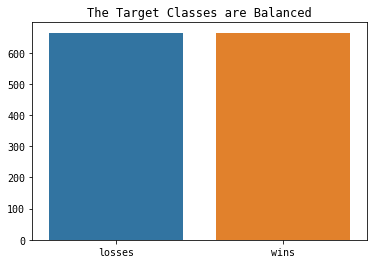

In [38]:
sns.countplot(y)
plt.xlabel(''), plt.ylabel('')
plt.xticks([0, 1], ('losses', 'wins'))
plt.title('The Target Classes are Balanced');

In [43]:
def clfy_report(clf, X_train, X_test, y_train, y_test, param_grid, clf_label='clf', cv=10, scale=True):
    """
    Tune classifier hyperparameters and print metrics.
    """
    from yellowbrick.classifier import ClassificationReport


    # Create pipeline steps for scaling and classifying:
    if scale:
        pipe = Pipeline([('scaler', StandardScaler()), (clf_label, clf)])
    else:
        pipe = Pipeline([(clf_label, clf)])
    
    # Instantiate grid search using 10-fold cross validation:
    search = GridSearchCV(pipe, param_grid, cv=10)
    
    # Learn relationship between predictors (basketball/tourney features) and outcome,
    # and the best parameters for defining such:
    search.fit(X_train, y_train)
    
    # Predictions on the test set, new data that haven't been introduced to the model:
    predicted = search.predict(X_test)
    
    # Predictions as probabilities:
    probabilities = search.predict_proba(X_test)[:, 1]
    
    # Accuracy scores for the training and test sets:
    train_accuracy = search.score(X_train, y_train)
    test_accuracy = search.score(X_test, y_test)

    print('Best Parameters: {}\n'.format(search.best_params_))
    print('Training Accuracy: {:0.2}'.format(train_accuracy))
    print('Test Accuracy: {:0.2}\n'.format(test_accuracy))
    
    # Confusion matrix labels:
    labels = np.array([['true losses','false wins'], ['false losses','true wins']])
    
    # Model evaluation metrics:
    confusion_mtrx = confusion_matrix(y_test, predicted)
    auc = roc_auc_score(y_test, probabilities)
    fpr, tpr, thresholds = roc_curve(y_test, probabilities)
    logloss = log_loss(y_test, search.predict_proba(X_test))
    
    # Plot all metrics in a grid of subplots:
    fig = plt.figure(figsize=(12, 12))
    grid = plt.GridSpec(2, 4, wspace=0.75, hspace=0.5)
    
    # Top-left plot - confusion matrix:
    plt.subplot(grid[0, :2])
    sns.heatmap(confusion_mtrx, annot=labels, fmt='')
    plt.xlabel('Predicted Games')
    plt.ylabel('Actual Games');
    
    # Top-right plot - ROC curve:
    plt.subplot(grid[0, 2:])
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUROC: {:0.3}'.format(auc));
    
    
    return search, train_accuracy, test_accuracy, auc, logloss

Best Parameters: {'clf__C': 0.1, 'clf__penalty': 'l2'}

Training Accuracy: 0.71
Test Accuracy: 0.66



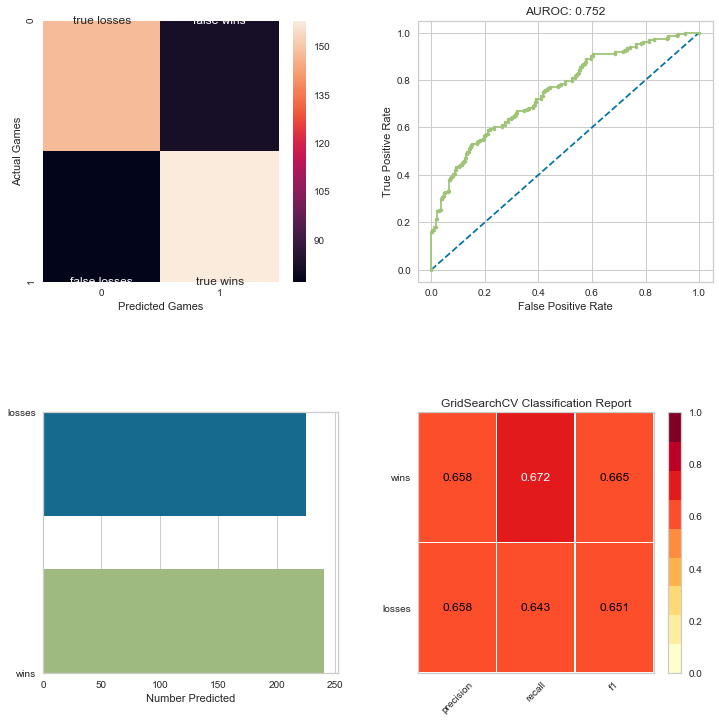

In [45]:
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

from sklearn.linear_model import LogisticRegression

# Tune Logistic Regression for optimal regularization strength
# and regularization method (penalty):
lr_clf = LogisticRegression(random_state=32)
lr_param_grid = {
    'clf__C': np.logspace(start=-10, stop=10, num=21),
    'clf__penalty': ['l1', 'l2']
}

lr_search, train_accuracy, test_accuracy, auc, logloss = clfy_report(
    lr_clf, 
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    lr_param_grid, 
    cv=10, 
    scale=True
)

Best Parameters: {'clf__criterion': 'entropy', 'clf__min_samples_leaf': 8, 'clf__n_estimators': 128}

Training Accuracy: 0.87
Test Accuracy: 0.65



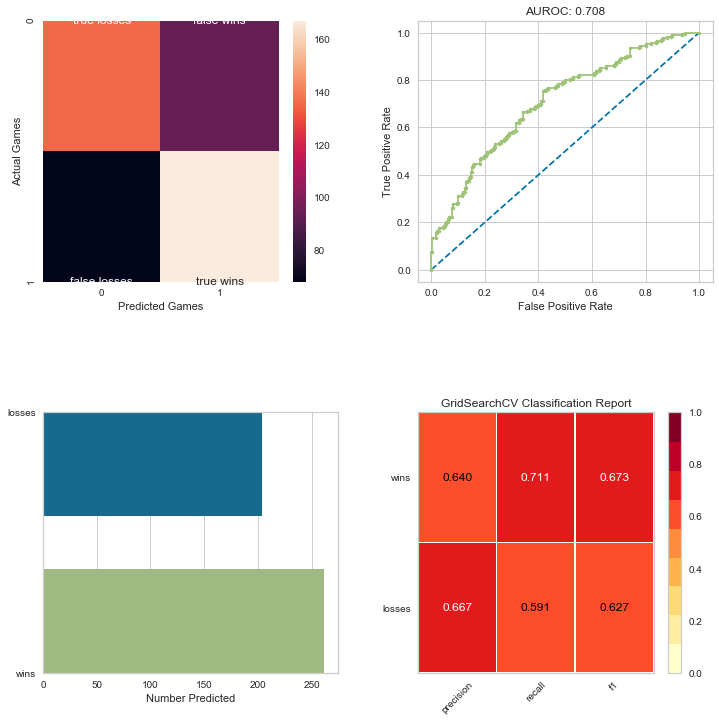

In [46]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=32, n_jobs=-1)
rf_param_grid = {
    'clf__n_estimators': [16, 32, 64, 128],
    'clf__min_samples_leaf': [2, 4, 8, 16], 
    'clf__criterion': ['entropy']
}

rf_search, train_accuracy, test_accuracy, auc, logloss = clfy_report(
    rf_clf, 
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    rf_param_grid, 
    cv=10, 
    scale=True
)

In [47]:
df_predict = pd.read_csv('H:/NCAA/NCAA2019/data/SampleSubmissionStage2.csv')
df_predict.head()

,ID,Pred
0,2019_1101_1113,0.5
1,2019_1101_1120,0.5
2,2019_1101_1124,0.5
3,2019_1101_1125,0.5
4,2019_1101_1133,0.5


In [48]:
def get_year_team1_team2(ID):
    """Return a tuple with the year, team1 and team2
    for each ID in the sample submission file of possible matches."""
    return (int(x) for x in ID.split('_'))

In [49]:
diff = []
data = []

for i, row in df_predict.iterrows():

    year, team1, team2 = get_year_team1_team2(row.ID)

    # Save 2018 stats/features for the first ID:
    team1 = df_features[(df_features['Season'] == year) & (df_features['TeamID'] == team1)].values[0]

    # Save 2018 stats/features for the first ID:
    team2 = df_features[(df_features['Season'] == year) & (df_features['TeamID'] == team2)].values[0]   

    diff = team1 - team2

    data.append(diff)

n_poss_games = len(df_predict)
columns = df_features.columns.get_values()
final_predictions = pd.DataFrame(np.array(data).reshape(n_poss_games, np.array(data).shape[1]), columns=(columns))
final_predictions.drop(['Season', 'TeamID'], inplace=True, axis=1)

In [50]:
predictions = lr_search.predict_proba(final_predictions)[:, 1]
clipped_predictions = np.clip(predictions, 0.05, 0.95)
df_predict.Pred = clipped_predictions

df_predict.to_csv('lr_search.csv', index=False)

In [51]:
predictions = rf_search.predict_proba(final_predictions)[:, 1]
clipped_predictions = np.clip(predictions, 0.05, 0.95)
df_predict.Pred = clipped_predictions

df_predict.to_csv('rf_search.csv', index=False)

In [52]:
%%capture
!pip install bracketeer

In [56]:
from bracketeer import build_bracket

b = build_bracket(
        outputPath='lr_search.png',
        submissionPath='lr_search.csv',
        teamsPath='H:/NCAA/NCAA2019/data/Stage2DataFiles/Teams.csv',
        seedsPath='H:/NCAA/NCAA2019/data/Stage2DataFiles/NCAATourneySeeds.csv',
        slotsPath='H:/NCAA/NCAA2019/data/Stage2DataFiles/NCAATourneySlots.csv',
        year=2019
)

b = build_bracket(
        outputPath='rf_search.png',
        submissionPath='rf_search.csv',
        teamsPath='H:/NCAA/NCAA2019/data/Stage2DataFiles/Teams.csv',
        seedsPath='H:/NCAA/NCAA2019/data/Stage2DataFiles/NCAATourneySeeds.csv',
        slotsPath='H:/NCAA/NCAA2019/data/Stage2DataFiles/NCAATourneySlots.csv',
        year=2019
)

In [57]:
perm = PermutationImportance(lr_search, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X_test.columns.tolist())

Weight,Feature
0.0052 ± 0.0126,seed_16
0.0047 ± 0.0092,seed_14
0.0034 ± 0.0162,seed_2
0.0026 ± 0.0164,seed_1
0.0026 ± 0.0042,seed_6
0.0022 ± 0.0112,off_rtg
0.0013 ± 0.0044,seed_12
0.0009 ± 0.0126,seed_13
0.0004 ± 0.0179,ie
0.0000 ± 0.0061,seed_4


In [ ]:
from bracketeer import build_bracket
b = build_bracket(
        output_path='H:/NCAA/NCAA2019/data/DataFiles/output.png', 
        teamsPath='H:/NCAA/NCAA2019/data/DataFiles/Teams.csv',
        seedsPath='H:/NCAA/NCAA2019/data/DataFiles/TourneySeeds.csv',
        submissionPath='H:/NCAA/NCAA2019/data/DataFiles/submit.csv',
        slotsPath='H:/NCAA/NCAA2019/data/DataFiles/TourneySlots.csv',
        year=2017
)

In [58]:
perm = PermutationImportance(rf_search, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X_test.columns.tolist())

Weight,Feature
0.0120 ± 0.0252,sos
0.0090 ± 0.0083,ie
0.0073 ± 0.0129,ft_rate
0.0043 ± 0.0054,reb_pct
0.0043 ± 0.0130,off_rtg
0.0043 ± 0.0161,drb_pct
0.0034 ± 0.0044,four
0.0030 ± 0.0080,3pta_pct
0.0030 ± 0.0104,seed_1
0.0022 ± 0.0000,seed_14


In [67]:
!pip list

Package                            Version  
---------------------------------- ---------
alabaster                          0.7.12   
anaconda-client                    1.7.2    
anaconda-navigator                 1.9.7    
anaconda-project                   0.8.3    
asn1crypto                         1.0.1    
astroid                            2.3.1    
astropy                            3.2.1    
atomicwrites                       1.3.0    
attrs                              19.2.0   
Babel                              2.7.0    
backcall                           0.1.0    
backports.functools-lru-cache      1.5      
backports.os                       0.1.1    
backports.shutil-get-terminal-size 1.0.0    
backports.tempfile                 1.0      
backports.weakref                  1.0.post1
beautifulsoup4                     4.8.0    
binarytree                         4.1.0    
bitarray                           1.0.1    
bkcharts                           0.2      
bleach    

In [1]:
cd

C:\Users\szj0062
